In [1]:
#dumb installs
%load_ext autoreload
%autoreload 2

import os
import astrophot as ap
import numpy as np
import torch
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

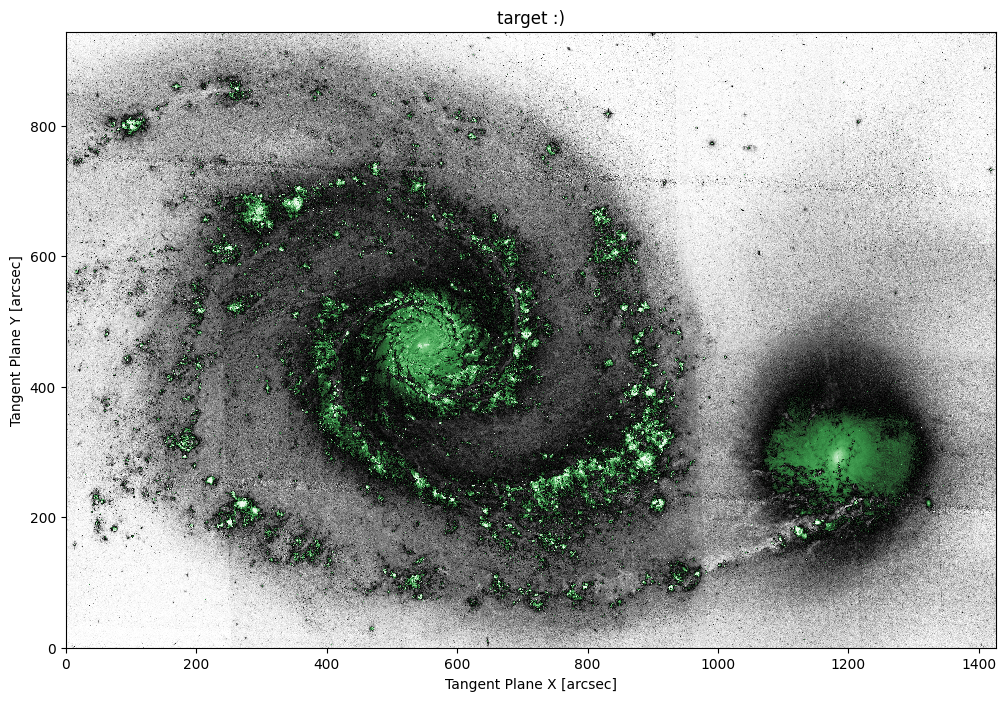

In [2]:
#making a target (basically data for the model to fit)
file = fits.open("cutouts/chandraWhirlpoolVisible.fits")
target_data = np.array(file[0].data, dtype = np.float64)
target_data = target_data.T

#target object
target = ap.image.Target_Image(
    data = target_data,
    pixelscale = 0.396, #SDSS pixel scale
    zeropoint = 22.3, #r-band in SDSS
    variance = np.ones(target_data.shape)/1e3,
)

# The default AstroPhot target plotting method uses log scaling in bright areas and histogram scaling in faint areas

fig, ax = plt.subplots(figsize = (12,8)) #fig is the figure, ax are the axes, figsize affects the literal size of the graph
ap.plots.target_image(fig, ax, target) #kernel crashes witg
plt.title("target :)")
plt.show()


In [3]:
model1 = ap.models.AstroPhot_Model(
    name = "model1", # every model must have a unique name
    model_type = "sersic galaxy model", # this specifies the kind of model
    #we don't need to list params because we have a target !
    target = target,
    window = [[300, 2500],[0,2300]]
)

#the model will try and guess the parameters it needs based on the target
#the galaxy has to be centered in the cutout though !
model1.initialize() # before using the model it is good practice to call initialize so the model can get itself ready

# We can print the model's current state
model1.parameters

model1 (id-140579820011328, branch node):
  center (id-140579821599136): [547.2782032775508, 455.5228319742591] +- [0.1, 0.1] [arcsec]
  q (id-140579821594000): 0.6 +- 0.03 [b/a], limits: (0.0, 1.0)
  PA (id-140579821599616): 0.9378609471158317 +- 0.06 [radians], limits: (0.0, 3.141592653589793), cyclic
  n (id-140579821599472): 1.2695495561763495 +- 0.05 [none], limits: (0.36, 8.0)
  Re (id-140579821599568): 887.7229618341973 +- 7037.809319976472 [arcsec], limits: (0.0, None)
  Ie (id-140579821599520): 4.523083667933133 +- 0.6093460619338122 [log10(flux/arcsec^2)]

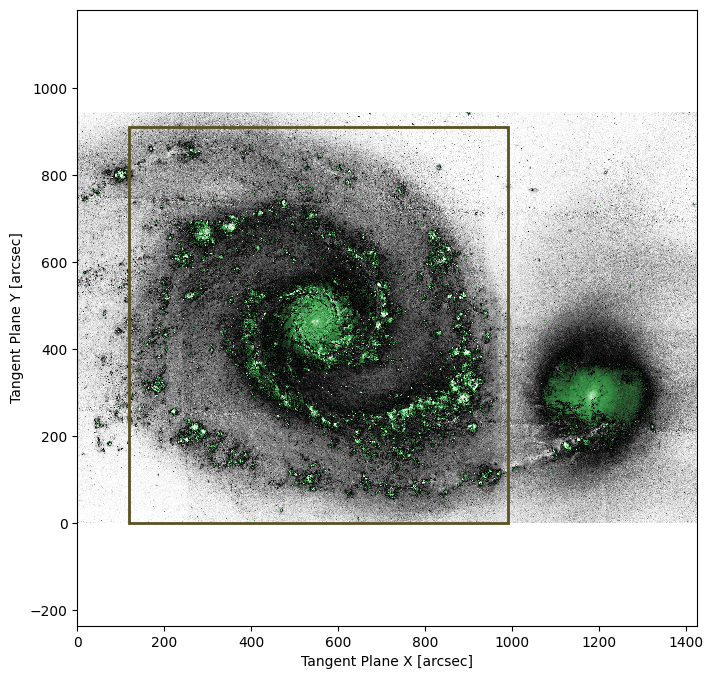

In [4]:
# We can plot the "model window" to show us what part of the image will be analyzed by that model
fig6, ax6 = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig6, ax6, model1.target)
ap.plots.model_window(fig6, ax6, model1)
plt.show()

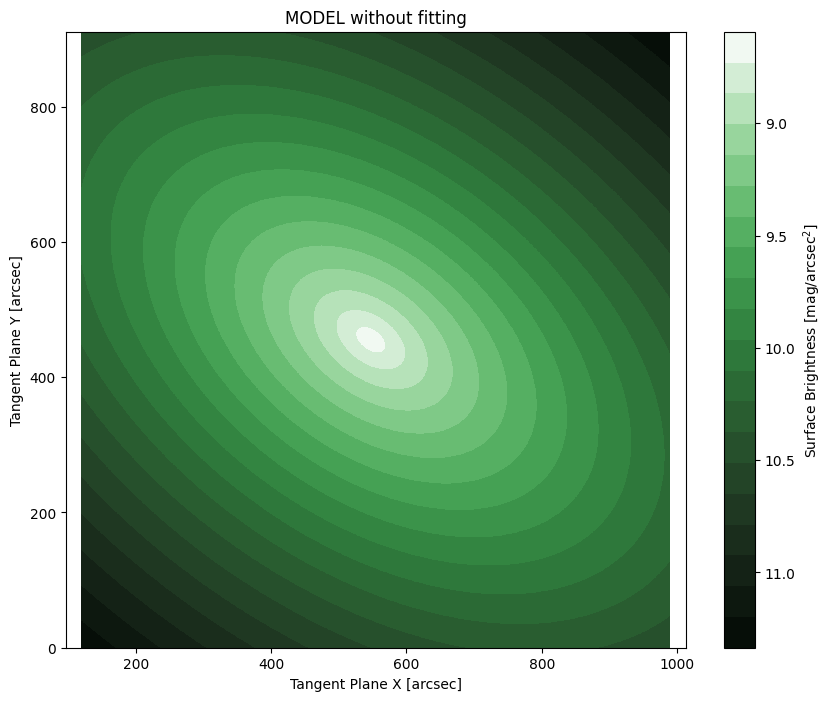

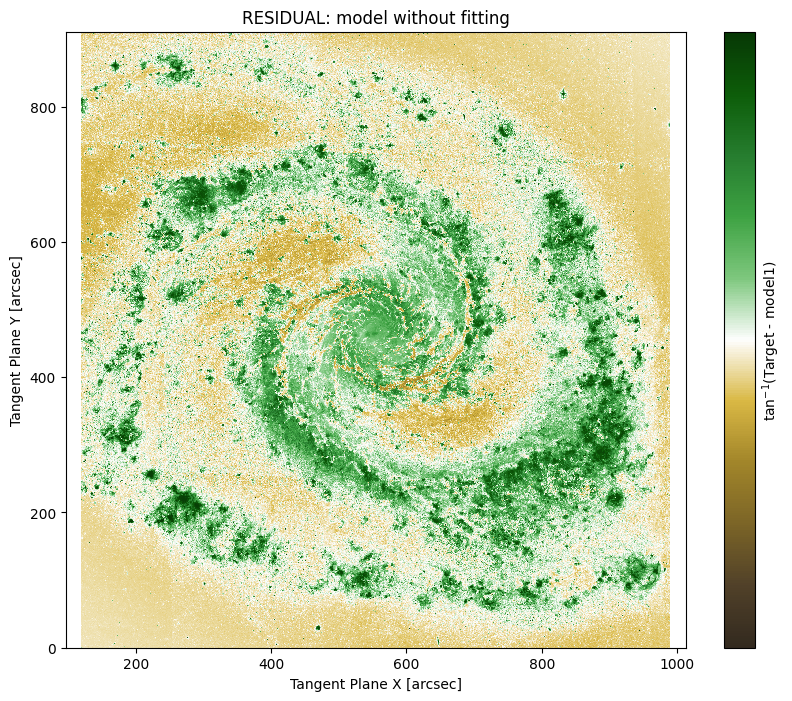

In [5]:
fig, ax = plt.subplots(figsize = (10,8))
ap.plots.model_image(fig, ax, model1, cmap_levels = 20) #cmap levels makes - levels :D
plt.title("MODEL without fitting")
plt.show()

fig1, ax1 = plt.subplots(figsize = (10,8))
ap.plots.residual_image(fig1, ax1, model1)
plt.title("RESIDUAL: model without fitting") #green is target, yellow is model
plt.show()

In [6]:
#using the LM optimiser (same one used at Western so...)

# Fit the parameters
result = ap.fit.lm.LM(model1, verbose = 0).fit() #verbose is 0 by default, the higher, the more detailed output

# Check that a minimum was found
print(result.message)

# See the minimum chi^2 value
print(f"min chi2: {result.res_loss()}")

# Update parameter uncertainties
result.update_uncertainty()

# Extract multivariate Gaussian of uncertainties
mu = result.res()
cov = result.covariance_matrix

success
min chi2: 83199019718.72728


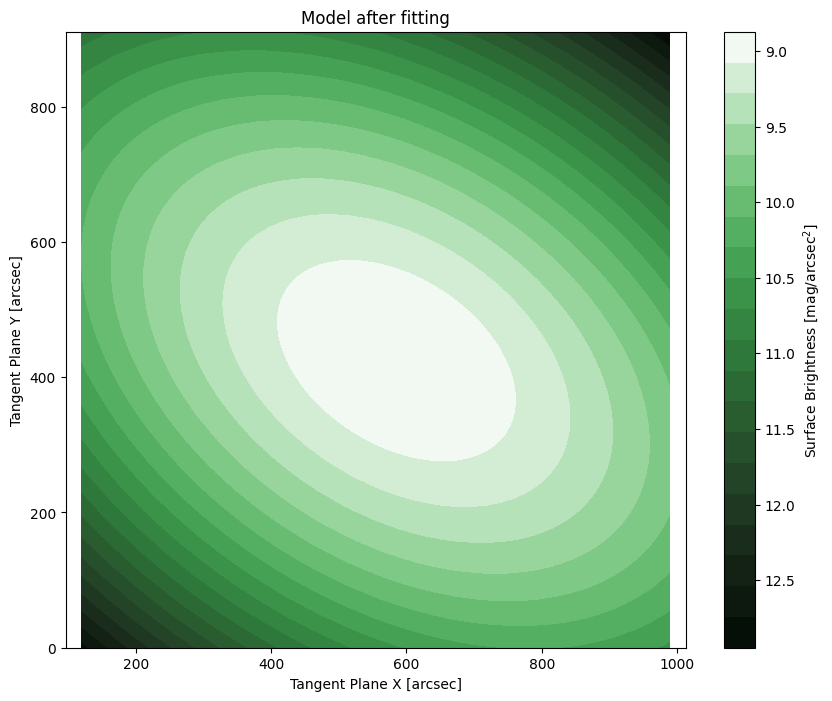

In [7]:
# plot the fit and residual fit SIDE BY SIDE
fig2, ax2 = plt.subplots(figsize = (10,8))
ap.plots.model_image(fig2, ax2, model1, cmap_levels = 20)
plt.title("Model after fitting")
plt.show()

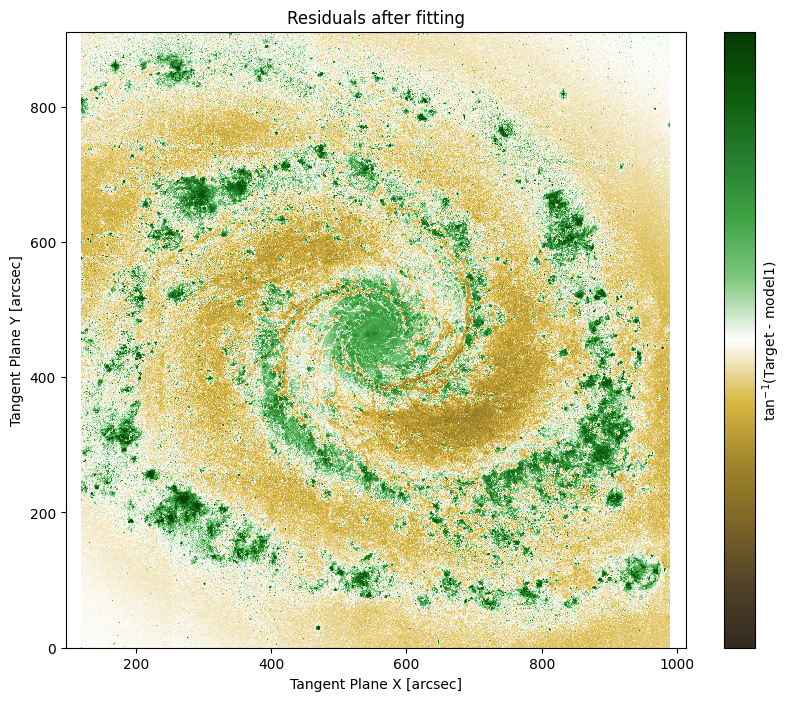

In [8]:
fig3, ax3 = plt.subplots(figsize = (10,8))
ap.plots.residual_image(fig3, ax3, model1)
plt.title("Residuals after fitting")
plt.show()

In [9]:
ap.image.target_image.Target_Image(data = target_data, pixelscale = 0.396)

image pixelscale: [[0.396 0.   ]
 [0.    0.396]] origin: [0. 0.] shape: [1425.6    944.064] center: [712.8   472.032]
data: [[ 771. 1542. 1285. ... 1799. 2056. 2056.]
 [2827. 3855. 2056. ... 2313. 2827. 3341.]
 [1028. 1285. 2056. ... 2827. 2570. 3084.]
 ...
 [1799. 1542. 1542. ... 1799. 2570.  771.]
 [2056. 1028. 1028. ... 3341.    0. 1028.]
 [1285. 1542. 1285. ... 2827. 2056. 3598.]]

Filename: cutouts/chandraWhirlpool.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   (2384, 3600)   int16 (rescales to uint16)   


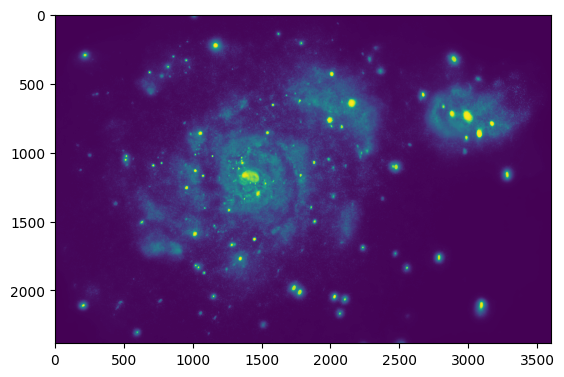

In [10]:
img_filename = "cutouts/chandraWhirlpool.fits"
img_data = fits.getdata(img_filename, ext = 0)
img_data = img_data.T
fits.info(img_filename)
plt.figure()
plt.imshow(img_data)